<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>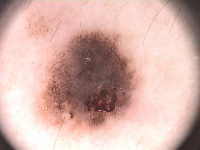</td><td>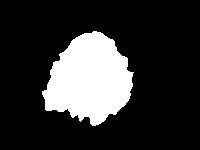</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!wget https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar #https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar

--2021-05-27 05:26:32--  https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4q6kwg8de56eqnc/PH2Dataset.rar [following]
--2021-05-27 05:26:32--  https://www.dropbox.com/s/raw/4q6kwg8de56eqnc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucacf9587530be62e8216b5e56a7.dl.dropboxusercontent.com/cd/0/inline/BPTpbA4UvvD4-opaAAjjKtF3SmLAiZfNqgKQZcihWzIFZm1Od1NskvZtoXe2lkB8YMTG1Q2s2xwB61mMjq1sDgEFCPD5Cm8Kf0nlVjw4je1IvXW1n4lc984UJbmI7RA0hg0oj8gx6Nx6NpI6bOhudjsj/file# [following]
--2021-05-27 05:26:32--  https://ucacf9587530be62e8216b5e56a7.dl.dropboxusercontent.com/cd/0/inline/BPTpbA4UvvD4-opaAAjjKtF3SmLAiZfNqgKQZcihWzIFZm1Od1NskvZtoXe2lkB8YMTG1Q2s2xwB61mMjq1

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


In [4]:
#!cd /content

In [3]:
!ls PH2Dataset

'PH2 Dataset images'   PH2_dataset.txt	 PH2_dataset.xlsx   Readme.txt


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
path = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(path, 'PH2 Dataset images')): # os.path.join(root, 'PH2 Dataset images')
    #print(root,dirs,files)
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [5]:
len(images[0])

572

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torch.utils.data import DataLoader
import random 
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

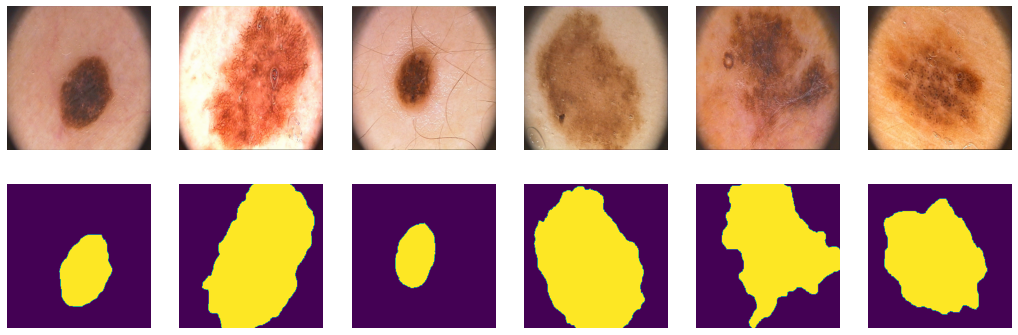

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [12]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [13]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [14]:
batch_size = 15
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [15]:
len(tr)

100

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

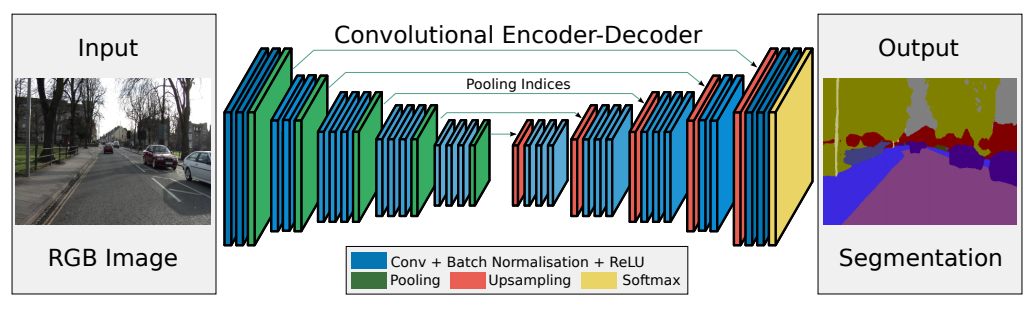

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [17]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64)
        ) # 256 -> 128
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2) #kernel_size=2, stride=2
          
        self.enc_conv1 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256),
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256),
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512)
        )

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.upsample2 =  nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.upsample3 =  nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1)
            #nn.Softmax()
        )

    def forward(self, x):
        # encoder
    
        e0 = self.enc_conv0(x)
        pooled_e0 = self.pool0(e0)
        
        e1 = self.enc_conv1(pooled_e0)
        pooled_e1 = self.pool1(e1)
       
        e2 = self.enc_conv2(pooled_e1)
        pooled_e2 = self.pool2(e2)
        
        e3 = self.enc_conv3(pooled_e2)
        pooled_e3 = self.pool3(e3)
        
        # bottleneck
        b = self.bottleneck_conv(pooled_e3)
        
        # decoder
        d0 = self.upsample0(b)
        upsampled_d0 = self.dec_conv0(d0)
        
        d1 = self.upsample0(upsampled_d0)
        upsampled_d1 = self.dec_conv1(d1)

        d2 = self.upsample0(upsampled_d1)
        upsampled_d2 = self.dec_conv2(d2)

        d3 =  self.upsample3(upsampled_d2)
        upsampled_d3 = self.dec_conv3(d3) # no activation
        return upsampled_d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [18]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte() #.type(torch.IntTensor).to(device)
    #outputs = int(torch.sigmoid(outputs) > 0.5)   # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte() #.to(device)
    SMOOTH = 1e-8
    intersection = (outputs & labels).sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return  iou #thresholded  

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [19]:
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch # max(y_pred, 0) - y_real*y_pred + torch.log(1+torch.exp(-1 * y_pred))
    y_pred = torch.sigmoid(y_pred)
    losses = y_pred - y_real*y_pred + torch.log(1+torch.exp(-torch.abs(y_pred)))
    return losses.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [21]:
# working

def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_history = []
    valid_history = []
    train_scores = []
    val_scores = []
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        history = []
        train_loss = 0
        valid_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
          
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch.to(device))  
            
            # calculate loss to show the user
            t_loss = loss_fn(Y_pred, Y_batch.to(device)) # forward-pass
            train_loss += t_loss.item()
            t_loss.backward()  # backward-pass
            opt.step()  # update weights
            
            train_score = score_model(model, iou_pytorch, data_tr)
            
            history.append(t_loss.cpu().data.numpy())
        toc = time()
        print('loss: %f' % train_loss)
        
        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
          
          Y_hat = model(X_val.to(device)) > 0 
          v_loss = loss_fn(Y_hat, Y_val.to(device)).cpu().numpy()
          valid_loss += v_loss.item()
          val_score = score_model(model, iou_pytorch, data_val)
          
          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), 'segnet-best-val-model.pt')
    
        # Visualize tools
        clear_output(wait=True)
        for k in range(5):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0].cpu().numpy() > 0, cmap='gray') # >0
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_loss))
        plt.show()
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
        
        ax[0].plot(history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        if train_history is not None:
            ax[1].plot(train_history, label='train history')
            ax[1].set_xlabel('Epoch')
            ax[1].set_title('Model loss')
            ax[1].set_ylabel('Loss')
        if valid_history is not None:
            ax[1].plot(valid_history, label='valid history')
        
        if train_scores is not None:
            ax[2].plot(train_scores, label='train accuracy')
            ax[2].set_xlabel('Epoch')
            ax[2].set_title('Model accuracy')
            ax[2].set_ylabel('Accuracy')
        if val_scores is not None:
            ax[2].plot(val_scores, label='valid accuracy')
        plt.legend()
        plt.show()
        train_scores.append(train_score / len(data_tr))
        val_scores.append(val_score / len(data_val))
        train_history.append(train_loss / len(data_tr))
        valid_history.append(valid_loss / len(data_val))
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        print(f'\tTrain Scores: {train_score:.3f}')
        print(f'\t Val. Scores: {val_score:.3f}')

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [22]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [23]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
      with torch.no_grad():
        Y_pred = model(X_batch.to(device)) 
        Y_pred = torch.where(Y_pred>0.5,1,0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [24]:
bce_model = SegNet().to(device)

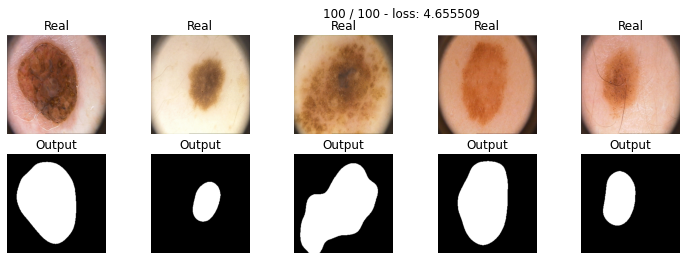

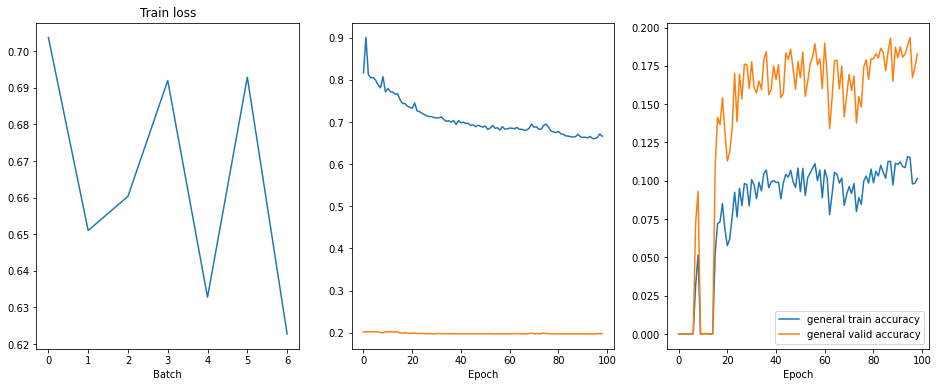

Epoch: 100
	Train Loss: 4.656
	 Val. Loss: 0.791
	Train Scores: 0.681
	 Val. Scores: 0.683


In [28]:
max_epochs = 100
optimizer = torch.optim.Adam(bce_model.parameters(), lr=1e-3)
train(bce_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [26]:
bce_segnet_accuracy = round(score_model(bce_model, iou_pytorch, data_val), 2) 
print(f'SegNet model with bce loss {bce_segnet_accuracy}')

SegNet model with bce loss 0.69


Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [37]:
def dice_loss(y_pred, y_real):
    smooth = 1
    y_pred = torch.sigmoid(y_pred)
    intersection = 2*(y_real*y_pred).sum()
    prob = (y_real + y_pred).sum()
    num = intersection + smooth #smooth
    den =  (prob + smooth)**(-1)
    res = 1 - (den * num)
    return res 

Проводим тестирование:

## SegNet with dice_loss


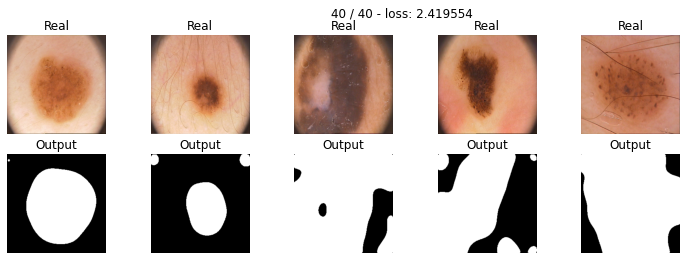

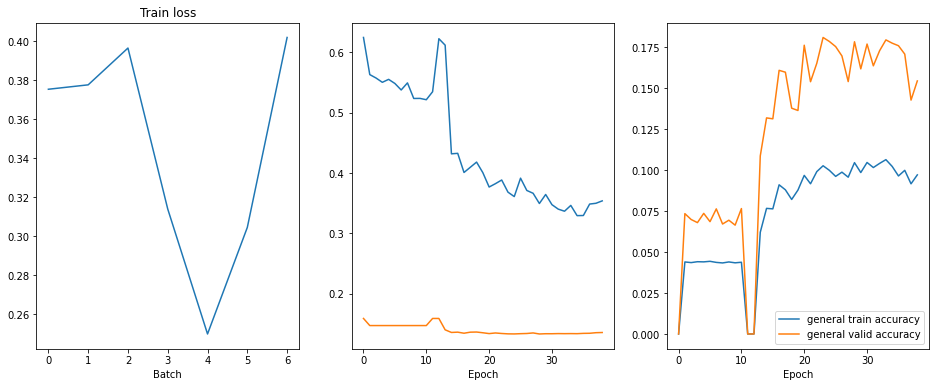

Epoch: 40
	Train Loss: 2.420
	 Val. Loss: 0.539
	Train Scores: 0.701
	 Val. Scores: 0.662


In [32]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [33]:
dice_segnet_accuracy = round(score_model(model_dice, iou_pytorch, data_val),2)
print(f'SegNet model with bce loss {dice_segnet_accuracy}')

SegNet model with bce loss 0.65


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [23]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred =  torch.sigmoid(y_pred) # hint: torch.clamp #p
    your_loss = (1 - y_pred)**gamma * y_real * torch.log(y_pred + eps) + (1-y_real) * y_pred**gamma * torch.log(1-y_pred + eps) #* y_pred**gamma
    
    return  -your_loss.mean()


## SegNet with focal_loss

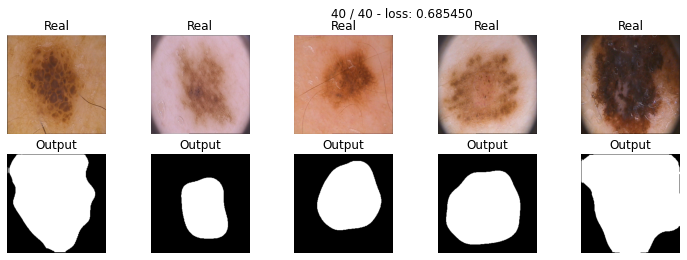

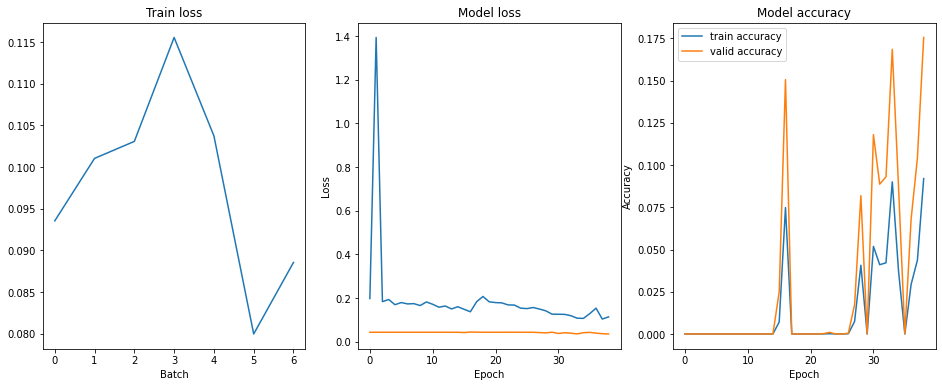

Epoch: 40
	Train Loss: 0.685
	 Val. Loss: 0.146
	Train Scores: 0.680
	 Val. Scores: 0.753


In [28]:
model_focal = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_focal.parameters())
train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [29]:
focal_segnet_accuracy = round(score_model(model_focal, iou_pytorch, data_val), 2)
print(f'SegNet model with focal loss {focal_segnet_accuracy}')

SegNet model with focal loss 0.75


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [35]:
def tversky_loss(y_pred, y_real, alpha=1e-8, beta=0.65):
    y_pred =  torch.sigmoid(y_pred) # References: https://arxiv.org/abs/1706.05721
    yy_pred = y_pred.flatten()
    yy_real = y_real.flatten()  
    true_pos = torch.sum(yy_real * yy_pred)
    false_neg = torch.sum(yy_real * (1 - yy_pred))
    false_pos = torch.sum((1 - yy_real) * yy_pred)
    res = (true_pos + alpha)/(true_pos + beta * false_neg + (1 - beta) * false_pos + alpha)
    return 1-res

## SegNet with tversky_loss

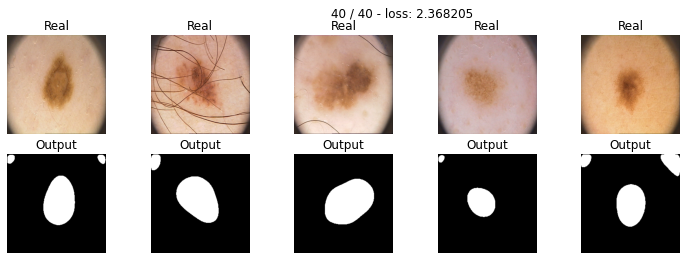

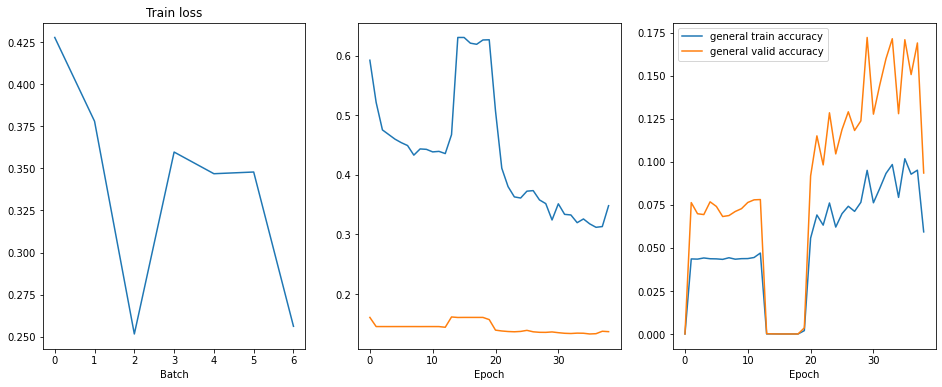

Epoch: 40
	Train Loss: 2.368
	 Val. Loss: 0.539
	Train Scores: 0.681
	 Val. Scores: 0.682


In [40]:
model_tversky = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_tversky.parameters())
train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

In [41]:
tversky_segnet_accuracy = round(score_model(model_tversky, iou_pytorch, data_val), 2)
print(f'SegNet model with bce loss {tversky_segnet_accuracy}')

SegNet model with bce loss 0.67


-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

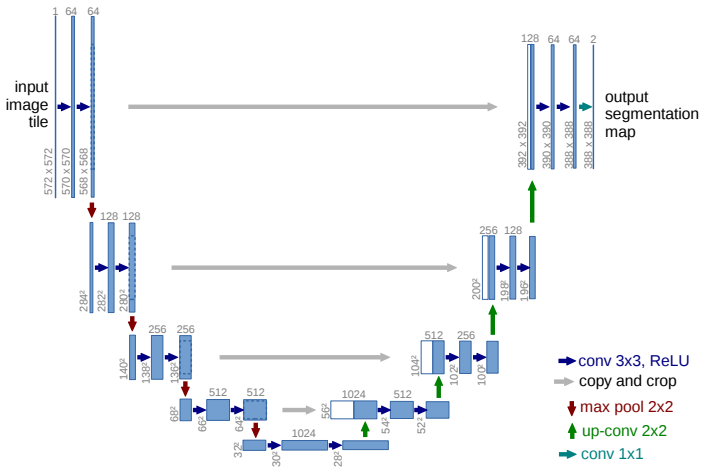

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [42]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        ) # 256 -> 128
        self.pool0 = nn.MaxPool2d(3, 2, padding=1) #kernel_size=2, stride=2
           # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(3, 2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(3, 2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) #nn.Upsample(scale_factor=2, mode='nearest') #nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32 #(16 +2*1 - 1)+1
        self.dec_conv0 = nn.Sequential(
                    nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) #nn.Upsample(scale_factor=2, mode='nearest') #nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) #nn.Upsample(scale_factor=2, mode='nearest') #nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # nn.Upsample(scale_factor=2, mode='nearest') # nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1),
                    nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        pooled_e0 = self.pool0(e0)

        e1 = self.enc_conv1(pooled_e0)
        pooled_e1 = self.pool1(e1)

        e2 = self.enc_conv2(pooled_e1)
        pooled_e2 = self.pool2(e2)

        e3 = self.enc_conv3(pooled_e2)
        pooled_e3 = self.pool3(e3)
        
        # bottleneck
        b = self.bottleneck_conv(pooled_e3)

        # decoder
        d0 = self.upsample0(b)
        d0_1 = torch.cat([d0, e3], dim=1)
        upsampled_d0 = self.dec_conv0(d0_1)
        
        d1 = self.upsample1(upsampled_d0)
        d1_1 = torch.cat([d1, e2], dim=1)
        upsampled_d1 = self.dec_conv1(d1_1)

        d2 = self.upsample2(upsampled_d1)
        d2_1 = torch.cat([d2, e1], dim=1)
        upsampled_d2 = self.dec_conv2(d2_1)
        
        d3 =  self.upsample3(upsampled_d2)
        d3_1 = torch.cat([d3, e0], dim=1)
        upsampled_d3 = self.dec_conv3(d3_1) # no activation
        
        return upsampled_d3

In [66]:
unet_model = UNet().to(device)


In [57]:
#torch.cuda.empty_cache()
!nvidia-smi

Wed May 26 18:59:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    37W / 250W |   9277MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## UNet with bce_loss

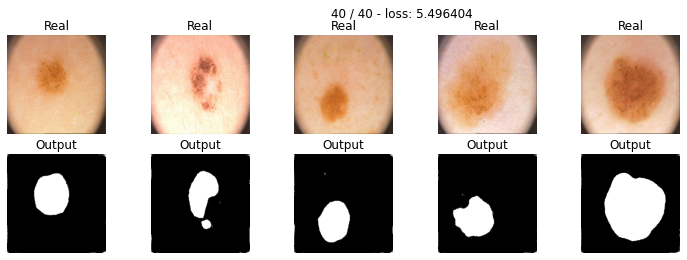

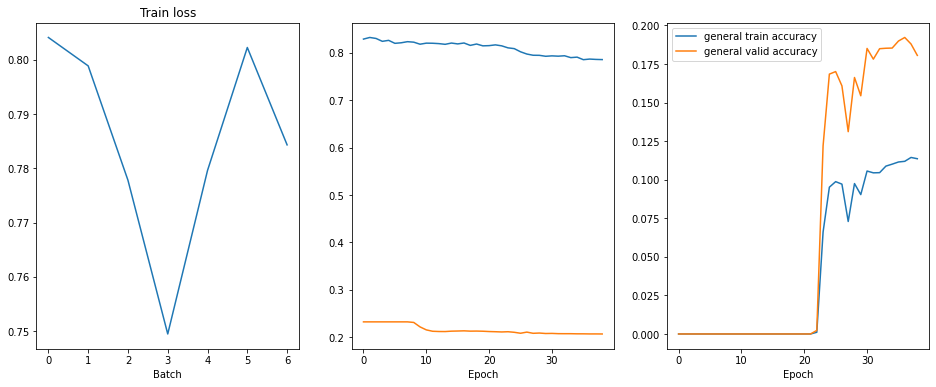

Epoch: 40
	Train Loss: 5.496
	 Val. Loss: 0.827
	Train Scores: 0.827
	 Val. Scores: 0.785


In [43]:
bce_unet_model = UNet().to(device)
epochs = 40
optimizer = optim.Adam(bce_unet_model.parameters(), lr=1e-5)
train(bce_unet_model, optimizer, bce_loss, epochs, data_tr, data_val)

In [44]:
bce_unet_accuracy = round(score_model(bce_unet_model, iou_pytorch, data_val),2)
print(f'UNet model with bce loss {bce_unet_accuracy}')

UNet model with bce loss 0.79


## UNet with dice_loss

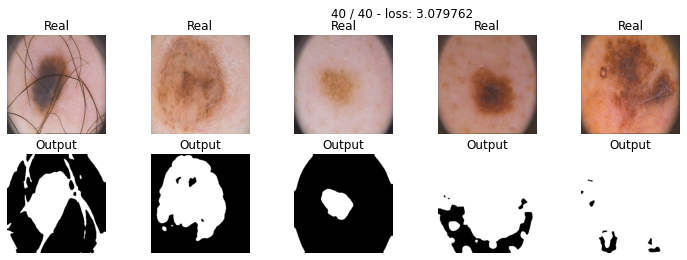

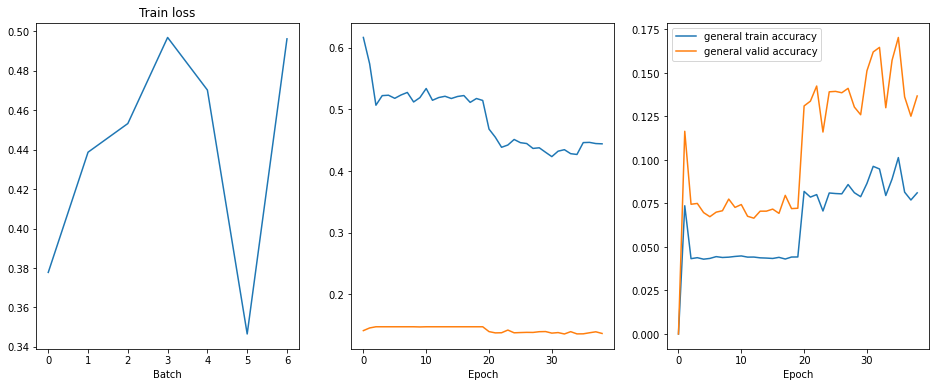

Epoch: 40
	Train Loss: 3.080
	 Val. Loss: 0.548
	Train Scores: 0.574
	 Val. Scores: 0.536


In [47]:
dice_unet_model = UNet().to(device)

max_epochs = 40
optimizer = optim.Adam(dice_unet_model.parameters()) #, lr=1e-06
train(dice_unet_model, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [50]:
dice_unet_accuracy = round(score_model(dice_unet_model, iou_pytorch, data_ts), 2)
print(f'UNet model with dice loss {dice_unet_accuracy}')

UNet model with dice loss 0.62


## UNet with focal_loss

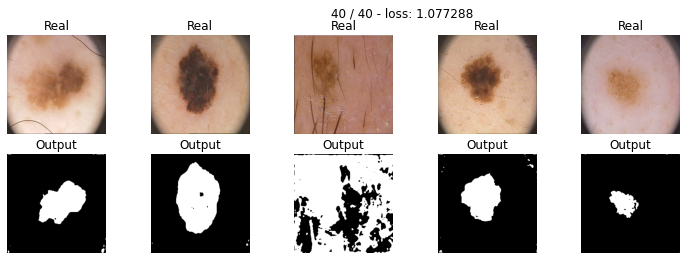

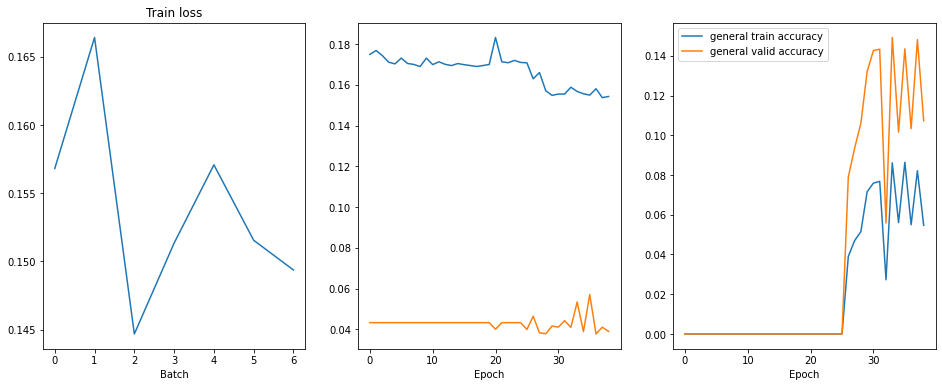

Epoch: 40
	Train Loss: 1.077
	 Val. Loss: 0.173
	Train Scores: 0.591
	 Val. Scores: 0.573


In [51]:
focal_unet_model = UNet().to(device)
max_epochs = 40
optimizer = optim.Adam(focal_unet_model.parameters())
train(focal_unet_model, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [52]:
focal_unet_accuracy = round(score_model(focal_unet_model, iou_pytorch, data_ts), 2)
print(f'UNet model with focal loss {focal_unet_accuracy}')

UNet model with focal loss 0.61


## UNet with tversky_loss

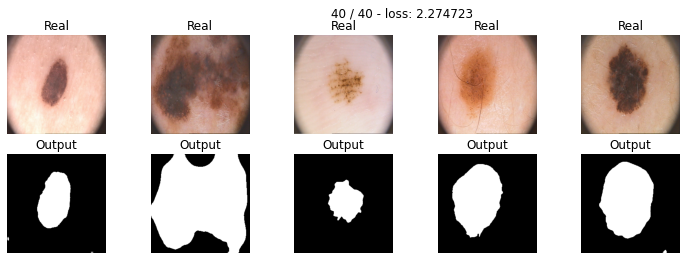

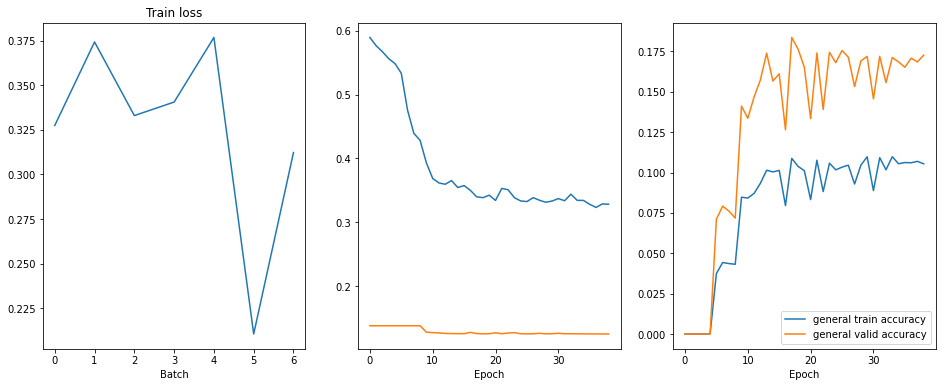

Epoch: 40
	Train Loss: 2.275
	 Val. Loss: 0.499
	Train Scores: 0.767
	 Val. Scores: 0.718


In [64]:
tversky_unet_model = UNet().to(device)
max_epochs = 40
optimizer = optim.Adam(tversky_unet_model.parameters(), lr=1e-4)
train(tversky_unet_model, optimizer, tversky_loss, max_epochs, data_tr, data_val)

In [65]:
tversky_unet_accuracy = round(score_model(tversky_unet_model, iou_pytorch, data_ts), 2)
print(f'UNet model with tversky loss {tversky_unet_accuracy}')

UNet model with tversky loss 0.77


Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [31]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        ) # 256 -> 128
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) #kernel_size=2, stride=2
           # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32 #(16 +2*1 - 1)+1
        self.dec_conv0 = nn.Sequential(
                    nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1),
                    nn.BatchNorm2d(1),
                    nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        pooled_e0 = self.pool0(e0)
        e1 = self.enc_conv1(pooled_e0)
        pooled_e1 = self.pool1(e1)
        e2 = self.enc_conv2(pooled_e1)
        pooled_e2 = self.pool2(e2)
        e3 = self.enc_conv3(pooled_e2)
        pooled_e3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(pooled_e3)

        # decoder
        d0 = self.upsample0(b)
        d0_1 = torch.cat([d0, e3], dim=1)
        upsampled_d0 = self.dec_conv0(d0_1)
      
        d1 = self.upsample1(upsampled_d0)
        d1_1 = torch.cat([d1, e2], dim=1)
        upsampled_d1 = self.dec_conv1(d1_1)
      
        d2 = self.upsample2(upsampled_d1)
        d2_1 = torch.cat([d2, e1], dim=1)
        upsampled_d2 = self.dec_conv2(d2_1)
     
        d3 =  self.upsample3(upsampled_d2)
        d3_1 = torch.cat([d3, e0], dim=1)
        upsampled_d3 = self.dec_conv3(d3_1) # no activation
        
        return upsampled_d3

## UNet2 with bce_loss

In [67]:
bce_unet2_model = UNet2().to(device)

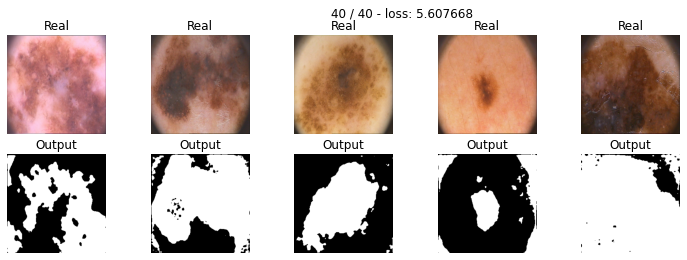

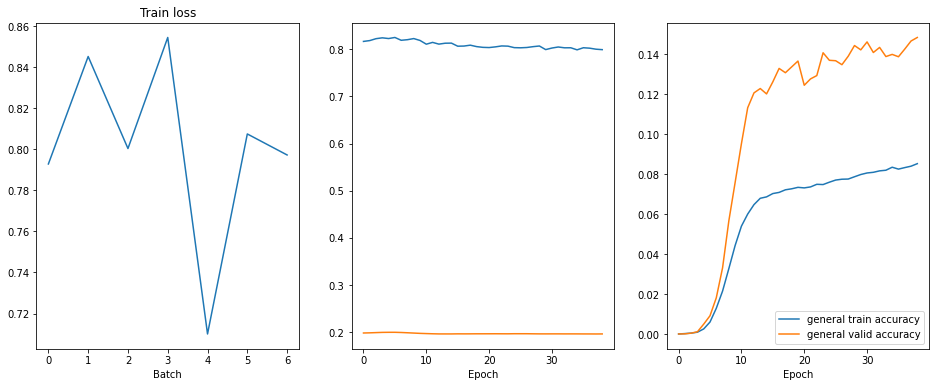

Epoch: 40
	Train Loss: 5.608
	 Val. Loss: 0.785
	Train Scores: 0.600
	 Val. Scores: 0.578


In [70]:
train(bce_unet2_model, optim.Adam(bce_unet2_model.parameters(), lr=1e-6), bce_loss, 40, data_tr, data_val)

In [71]:
bce_unet2_accuracy = round(score_model(bce_unet2_model, iou_pytorch, data_ts), 2)
print(f'UNet2 model with bce loss {bce_unet2_accuracy}')

UNet2 model with bce loss 0.61


## UNet2 with dice_loss

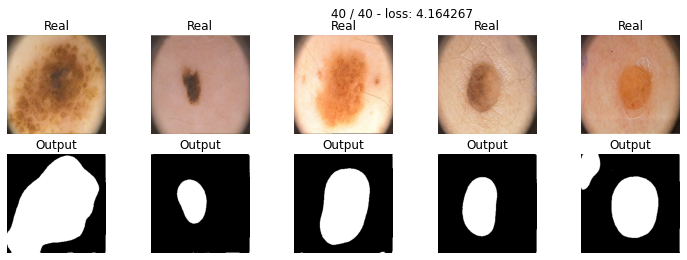

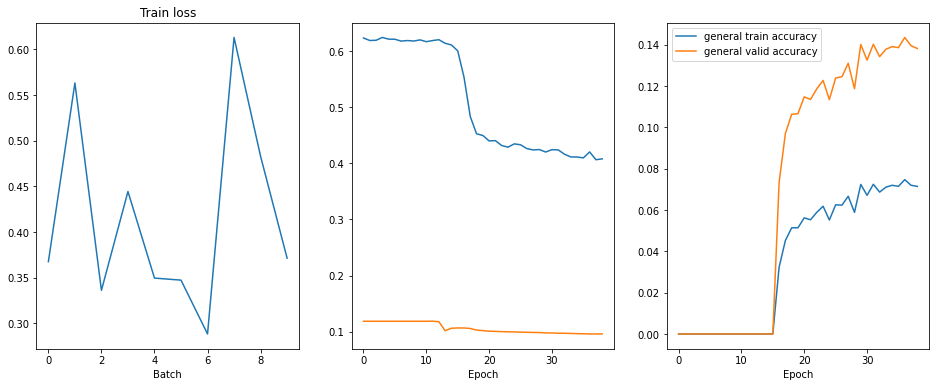

Epoch: 40
	Train Loss: 4.164
	 Val. Loss: 0.480
	Train Scores: 0.726
	 Val. Scores: 0.700


In [79]:
train(unet2_model, optim.Adam(unet2_model.parameters(), lr=1e-5), dice_loss, 40, data_tr, data_val)

In [80]:
dice_unet2_accuracy = round(score_model(unet2_model, iou_pytorch, data_ts), 2)
print(f'UNet2 model with dice loss {dice_unet2_accuracy}')

UNet2 model with dice loss 0.68


## UNet2 with focal_loss

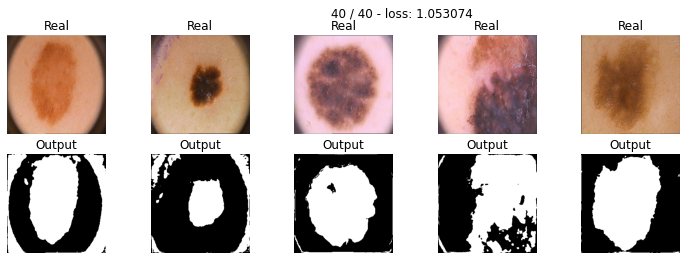

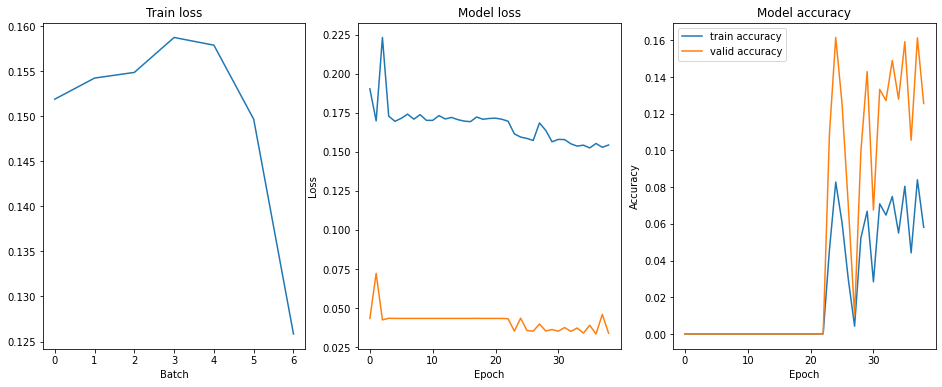

Epoch: 40
	Train Loss: 1.053
	 Val. Loss: 0.153
	Train Scores: 0.541
	 Val. Scores: 0.606


In [32]:
focal_unet2_model = UNet2().to(device)
train(focal_unet2_model, optim.Adam(focal_unet2_model.parameters()), focal_loss, 40, data_tr, data_val)

In [33]:
focal_unet2_accuracy = round(score_model(focal_unet2_model, iou_pytorch, data_ts), 2)
print(f'UNet2 model with focal loss {focal_unet2_accuracy}')

UNet2 model with focal loss 0.58


## UNet2 with tversky_loss

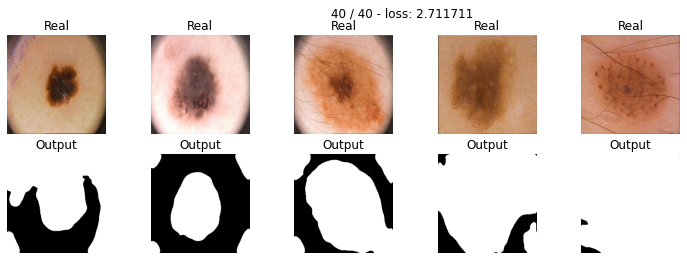

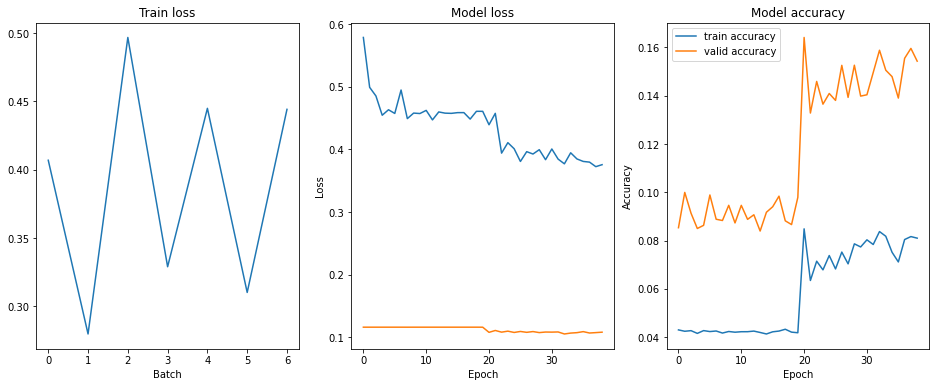

Epoch: 40
	Train Loss: 2.712
	 Val. Loss: 0.436
	Train Scores: 0.516
	 Val. Scores: 0.572


In [36]:
tversky_unet2_model = UNet2().to(device)
train(tversky_unet2_model, optim.Adam(tversky_unet2_model.parameters()), tversky_loss, 40, data_tr, data_val)

In [38]:
tversky_unet2_accuracy = round(score_model(tversky_unet2_model, iou_pytorch, data_ts), 2)
print(f'UNet2 model with tversky loss {tversky_unet2_accuracy}')

UNet2 model with tversky loss 0.53


Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Были реализованы три архитектуры: SegNet, UNet и UNet2. 
Каждая модель была обучена с использованием 4 разных функций потерь: CrossEntropy loss, dice loss, focal loss, tversky loss.  Результаты обучения приведены в сводной таблице result. Судя по результатам, наилучшее качество было достигнуто моделью UNet с loss-фукцией binary cross-entropy (score = 0.79), на следующем месте UNet c tversky loss -- качество 0.77, на третьем месте - SegNet c focal loss -- 0.75.  UNet2 не показал впечатляющих результатов.

In [41]:
import pandas as pd

data = [['BCE_Loss', bce_segnet_accuracy, bce_unet_accuracy, bce_unet2_accuracy],\
        ['Dice_Loss', dice_segnet_accuracy, dice_unet_accuracy, dice_unet2_accuracy],\
        ['Focal_Loss', focal_segnet_accuracy, focal_unet_accuracy, focal_unet2_accuracy],
        ['Tversky_Loss', tversky_segnet_accuracy, tversky_unet_accuracy, tversky_unet2_accuracy]]
result = pd.DataFrame(data, columns = ['Losses', 'SegNet', 'UNet', 'UNet2'])

In [42]:
result

,Losses,SegNet,UNet,UNet2
0,BCE_Loss,0.69,0.79,0.61
1,Dice_Loss,0.65,0.62,0.68
2,Focal_Loss,0.75,0.61,0.58
3,Tversky_Loss,0.67,0.77,0.53
